<a href="https://colab.research.google.com/github/UtwoA/Introduction_to_ML/blob/main/ml5part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install minisom

In [28]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [29]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [30]:
bank_data = pd.read_csv("Banks.txt", sep="\t", encoding="cp1251")
bank_data.head()

features_A = [
    "Филиалы",
    "Сумма активов",
    "Собственные активы",
    "Банковские активы",
    "Средства в Банке"
]
target = "Прибыль"

selected_columns = ["Номер", "Банк", *features_A, target]
df = bank_data[selected_columns].dropna()

print(f"Размер набора данных: {df.shape}")

Размер набора данных: (99, 8)


In [31]:
scaler_A = StandardScaler()
scaled_A = scaler_A.fit_transform(df[features_A])

net_size = (2, 2)
som_A = MiniSom(*net_size, input_len=scaled_A.shape[1],
                sigma=1.0, learning_rate=0.5, random_seed=42)
som_A.random_weights_init(scaled_A)
som_A.train_random(scaled_A, 4000)

winners_A = [som_A.winner(vec) for vec in scaled_A]
mapping_A = {node: i for i, node in enumerate(sorted(set(winners_A)))}
df["Cluster1"] = [mapping_A[node] for node in winners_A]

cluster_count_A = df["Cluster1"].value_counts().sort_index()
cluster_count_A

,count
Cluster1,
0,5
1,16
2,77
3,1


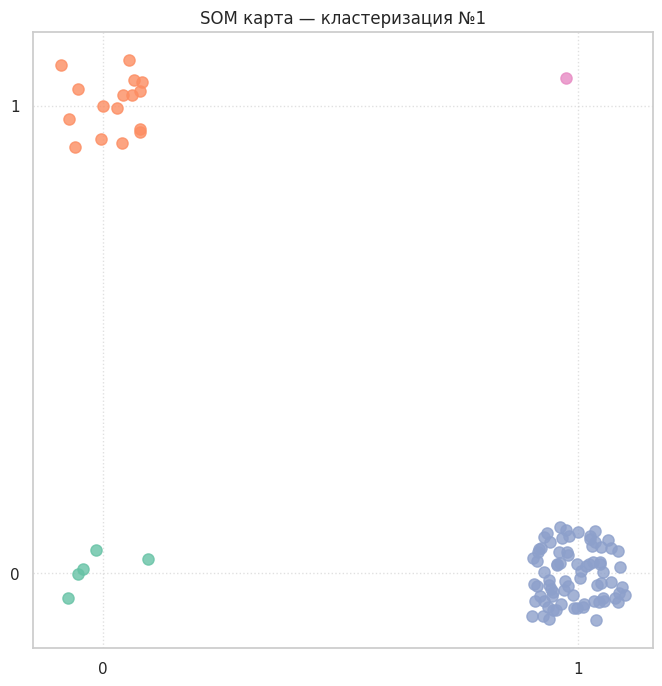

,count
Cluster1,
0,5
1,16
2,77
3,1


In [32]:
colors1 = sns.color_palette("Set2", n_colors=len(cluster_count_A))
plt.figure(figsize=(8, 8))
for (nx, ny), cid in zip(winners_A, df["Cluster1"]):
    plt.scatter(nx + np.random.uniform(-.1, .1),
                ny + np.random.uniform(-.1, .1),
                s=65, alpha=.8, color=colors1[cid])

plt.xticks(range(net_size[0]))
plt.yticks(range(net_size[1]))
plt.title("SOM карта — кластеризация №1")
plt.grid(ls=":", alpha=.6)
plt.show()

cluster_count_A

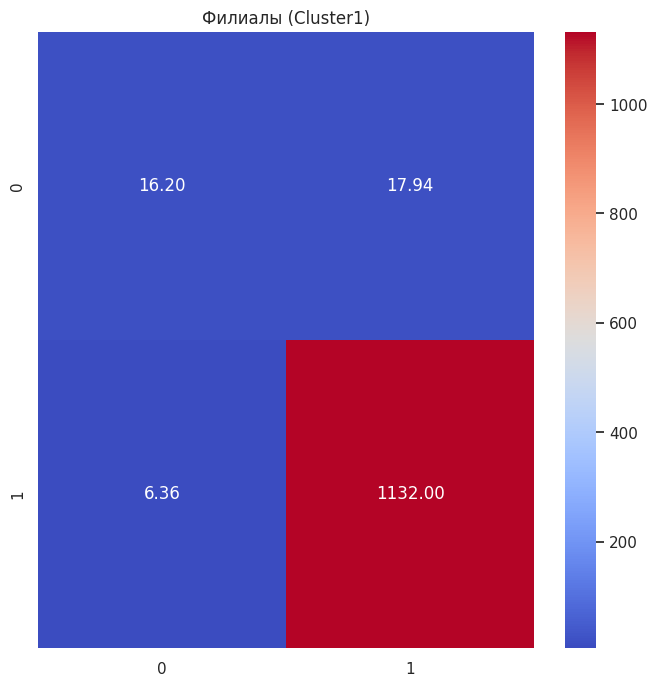

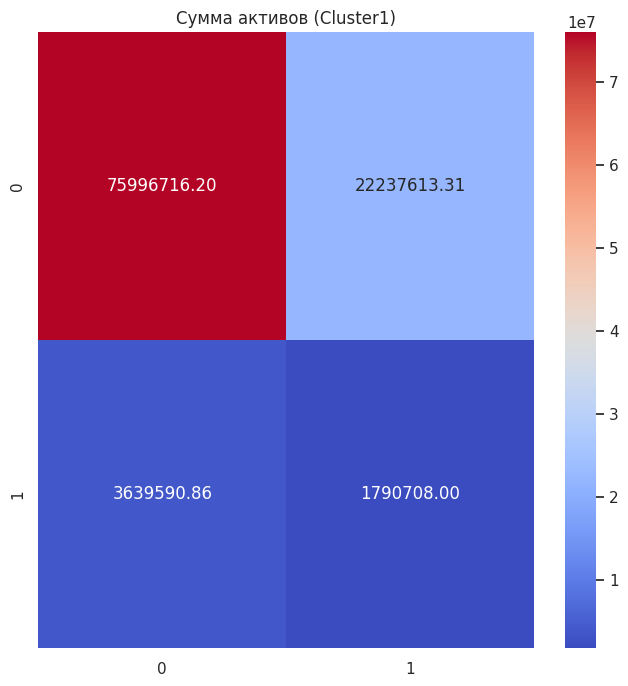

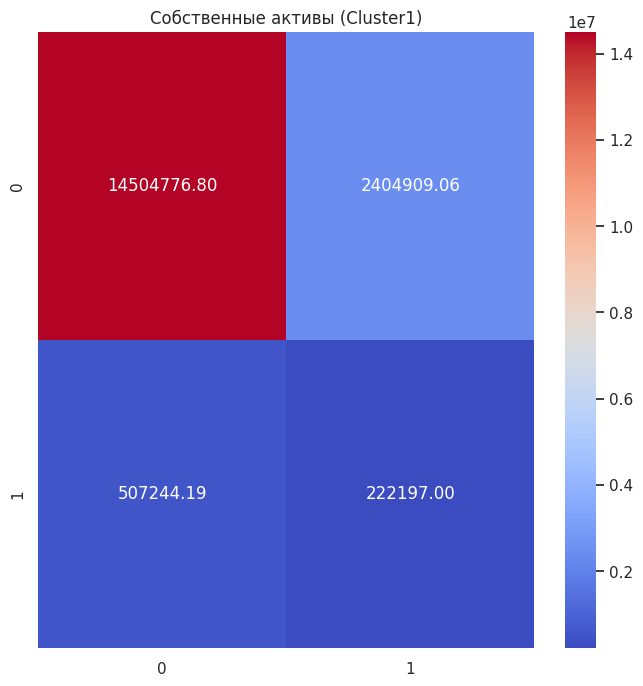

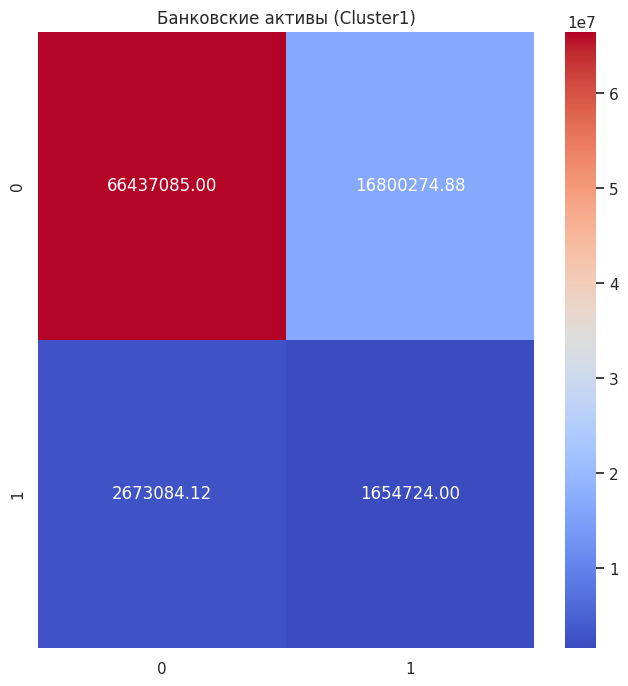

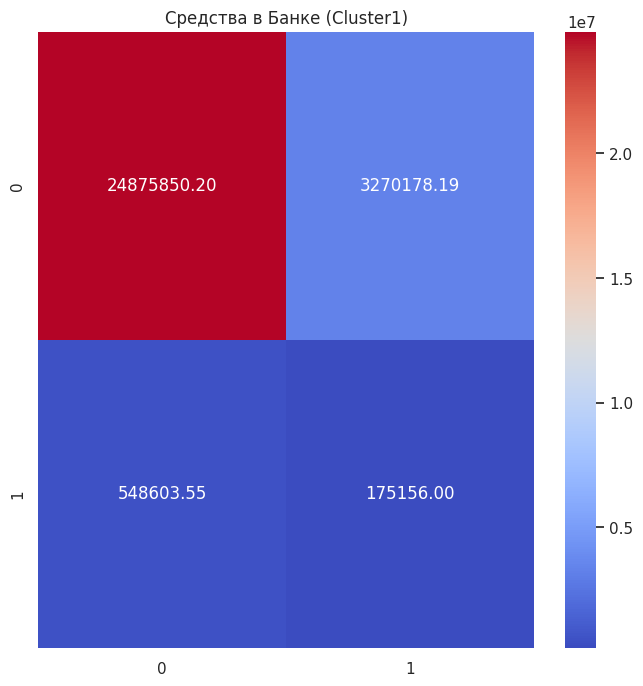

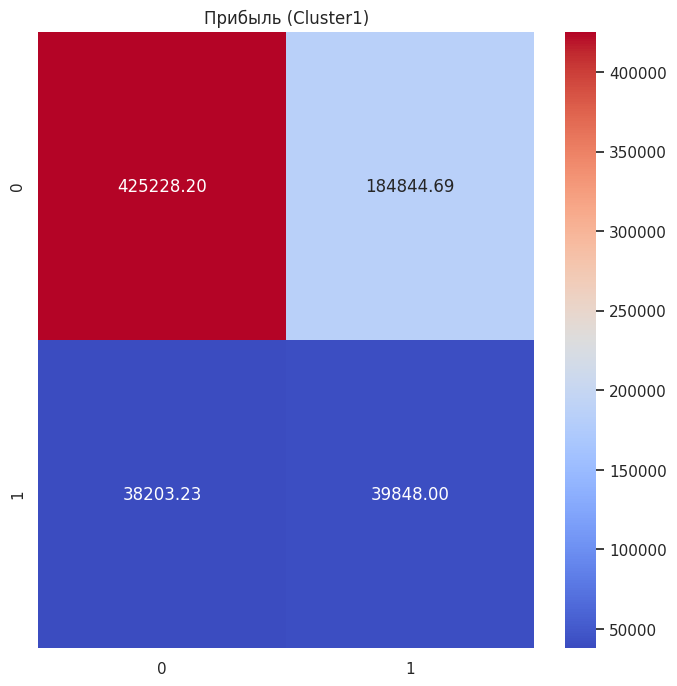

In [33]:
def draw_feature_heatmap(data, cluster_name, feature_name, tag="(Cluster1)"):
    stat = data.groupby(cluster_name)[feature_name].mean()
    heat = np.full(net_size, np.nan)

    for coord, cid in mapping_A.items():
        heat[coord] = stat.loc[cid]

    plt.figure(figsize=(8, 8))
    sns.heatmap(heat, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"{feature_name} {tag}")
    plt.show()


for f in features_A + [target]:
    draw_feature_heatmap(df, "Cluster1", f)

In [34]:
min_cl = cluster_count_A.idxmin()
least_group = df.query("Cluster1 == @min_cl")
print(f"\nНаименьший кластер: {min_cl} (всего {len(least_group)})")
least_group[["Банк", *features_A, target]]


Наименьший кластер: 3 (всего 1)


,Банк,Филиалы,Сумма активов,Собственные активы,Банковские активы,Средства в Банке,Прибыль
77,"ОАО ""СОЦИНВЕСТБАНК""",1132,1790708,222197,1654724,175156,39848


In [35]:
result1 = []
for feat in features_A + [target]:
    groups = [grp[feat].values for _, grp in df.groupby("Cluster1")]
    f, p = stats.f_oneway(*groups)

    for c, grp in df.groupby("Cluster1"):
        mean, std, n = grp[feat].mean(), grp[feat].std(), grp.shape[0]
        result1.append({
            "Показатель": feat,
            "Кластер": c,
            "Среднее": mean,
            "95% CI": 1.96 * std / np.sqrt(n),
            "p-value": p,
            "N": n
        })

summary_A = pd.DataFrame(result1)
summary_A

,Показатель,Кластер,Среднее,95% CI,p-value,N
0,Филиалы,0,1.620000e+01,1.197687e+01,7.338509e-94,5
1,Филиалы,1,1.793750e+01,9.983612e+00,7.338509e-94,16
2,Филиалы,2,6.363636e+00,2.030381e+00,7.338509e-94,77
3,Филиалы,3,1.132000e+03,NaN,7.338509e-94,1
4,Сумма активов,0,7.599672e+07,1.492104e+07,1.300774e-47,5
5,Сумма активов,1,2.223761e+07,4.532036e+06,1.300774e-47,16
6,Сумма активов,2,3.639591e+06,6.033711e+05,1.300774e-47,77
7,Сумма активов,3,1.790708e+06,NaN,1.300774e-47,1
8,Собственные активы,0,1.450478e+07,9.060540e+06,2.603788e-22,5
9,Собственные активы,1,2.404909e+06,7.491208e+05,2.603788e-22,16


/tmp/ipython-input-1039642905.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Cluster1", y="Сумма активов", palette=colors1, ax=axes[0])
/tmp/ipython-input-1039642905.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x="Cluster1", y="Сумма активов",


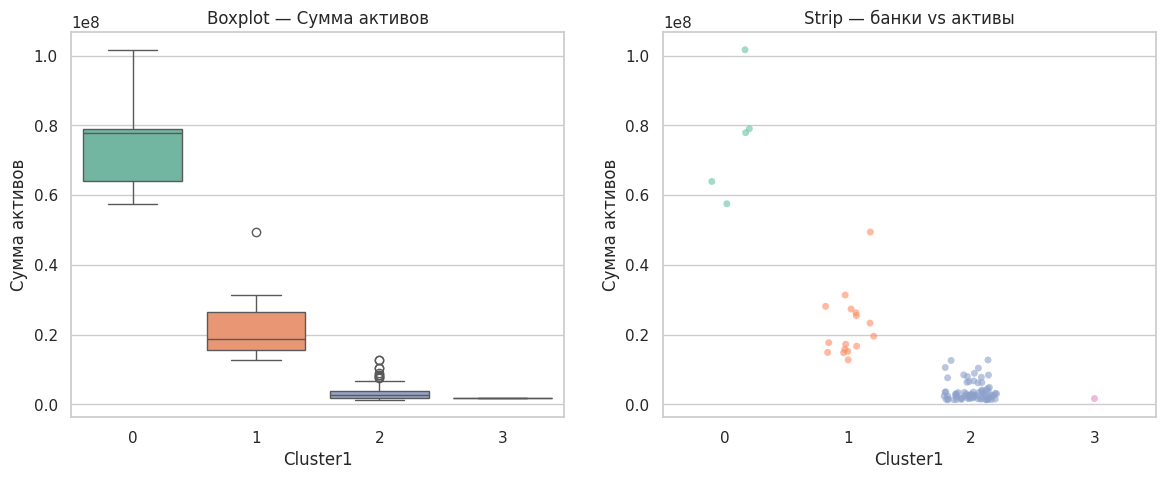


p-value по признаку «Филиалы»: 0.0000


/tmp/ipython-input-1039642905.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Cluster1", y="Филиалы", palette=colors1)


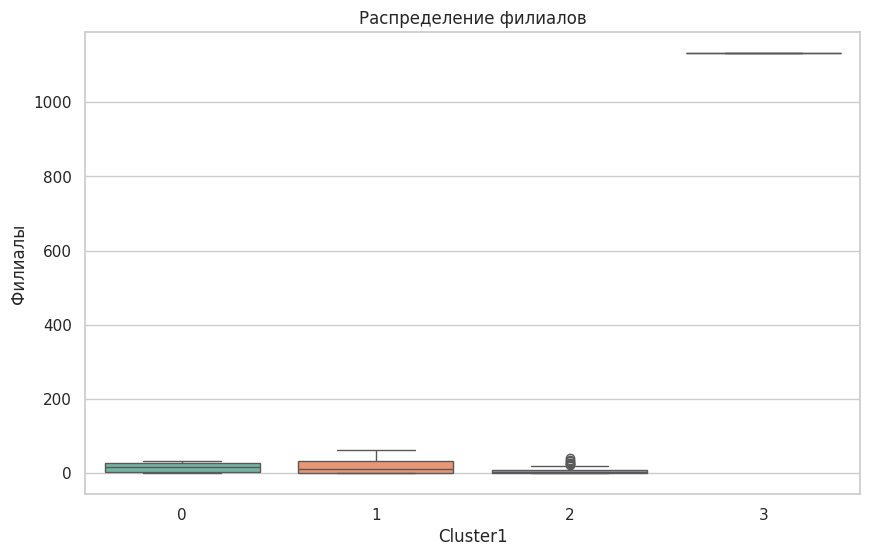

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df, x="Cluster1", y="Сумма активов", palette=colors1, ax=axes[0])
sns.stripplot(data=df, x="Cluster1", y="Сумма активов",
              palette=colors1, jitter=.22, alpha=.6, ax=axes[1])

axes[0].set_title("Boxplot — Сумма активов")
axes[1].set_title("Strip — банки vs активы")

plt.show()

p_f = summary_A.loc[summary_A["Показатель"] == "Филиалы", "p-value"].iloc[0]
print(f"\np-value по признаку «Филиалы»: {p_f:.4f}")

sns.boxplot(data=df, x="Cluster1", y="Филиалы", palette=colors1)
plt.title("Распределение филиалов")
plt.show()

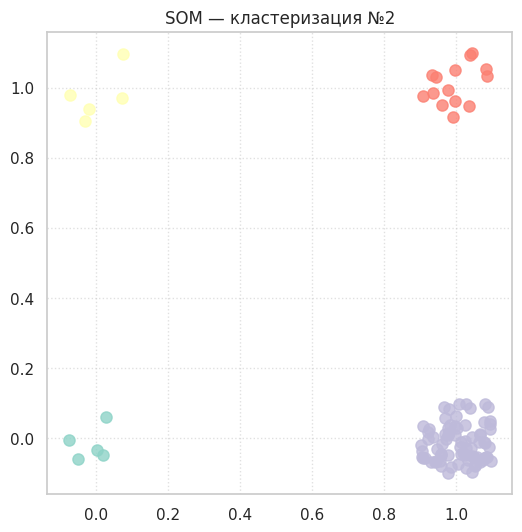

In [37]:
features_B = ["Прибыль", "Сумма активов", "Собственные активы",
              "Банковские активы", "Средства в Банке"]

scaler_B = StandardScaler()
scaled_B = scaler_B.fit_transform(df[features_B])

som_B = MiniSom(*net_size, input_len=scaled_B.shape[1],
                sigma=1.0, learning_rate=0.5, random_seed=42)
som_B.random_weights_init(scaled_B)
som_B.train_random(scaled_B, 4000)

winners_B = [som_B.winner(v) for v in scaled_B]
map_B = {node: i for i, node in enumerate(sorted(set(winners_B)))}
df["Cluster2"] = [map_B[n] for n in winners_B]

cluster_count_B = df["Cluster2"].value_counts().sort_index()
cluster_count_B

plt.figure(figsize=(6, 6))
colors2 = sns.color_palette("Set3", n_colors=len(cluster_count_B))
for (a, b), lid in zip(winners_B, df["Cluster2"]):
    plt.scatter(a + np.random.uniform(-.1,.1),
                b + np.random.uniform(-.1,.1),
                color=colors2[lid], s=65, alpha=.8)
plt.title("SOM — кластеризация №2")
plt.grid(ls=":", alpha=.6)
plt.show()


In [38]:
profit_stats = []
vals2 = [g[target].values for _, g in df.groupby("Cluster2")]
f2, p2 = stats.f_oneway(*vals2)

for c, g in df.groupby("Cluster2"):
    profit_stats.append({
        "Кластер": c,
        "Средняя прибыль": g[target].mean(),
        "95% CI": 1.96 * g[target].std() / np.sqrt(len(g)),
        "p-value": p2,
        "N": len(g)
    })

summary_B = pd.DataFrame(profit_stats)
summary_B

,Кластер,Средняя прибыль,95% CI,p-value,N
0,0,412636.600000,212597.752096,2.567336e-15,5
1,1,425228.200000,406915.715280,2.567336e-15,5
2,2,24073.426667,7937.168214,2.567336e-15,75
3,3,147880.142857,50905.106313,2.567336e-15,14


In [39]:
print("\nПерекрёстная матрица (Cluster1 → Cluster2):")
pd.crosstab(df["Cluster1"], df["Cluster2"], normalize="index")


Перекрёстная матрица (Cluster1 → Cluster2):


Cluster2,0,1,2,3
Cluster1,,,,
0,0.0000,1.0,0.000000,0.000000
1,0.3125,0.0,0.125000,0.562500
2,0.0000,0.0,0.935065,0.064935
3,0.0000,0.0,1.000000,0.000000
